
Preview of Final Regression & Spearman Correlation Results Table:
                  Dataset                      Model    Metric  \
4   Heart Disease Dataset         Decision Tree (DT)  Accuracy   
8   Heart Disease Dataset         Decision Tree (DT)  F1 Score   
2   Heart Disease Dataset         Decision Tree (DT)        FN   
1   Heart Disease Dataset         Decision Tree (DT)        FP   
7   Heart Disease Dataset         Decision Tree (DT)       PPV   
0   Heart Disease Dataset         Decision Tree (DT)        TN   
6   Heart Disease Dataset         Decision Tree (DT)       TNR   
3   Heart Disease Dataset         Decision Tree (DT)        TP   
5   Heart Disease Dataset         Decision Tree (DT)       TPR   
13  Heart Disease Dataset  K-Nearest Neighbors (KNN)  Accuracy   
17  Heart Disease Dataset  K-Nearest Neighbors (KNN)  F1 Score   
11  Heart Disease Dataset  K-Nearest Neighbors (KNN)        FN   
10  Heart Disease Dataset  K-Nearest Neighbors (KNN)        FP   
16  Heart

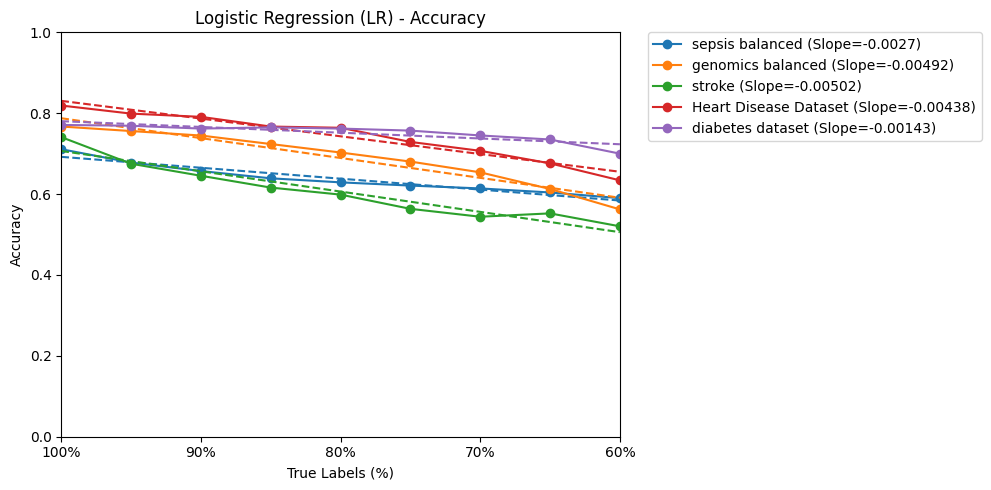

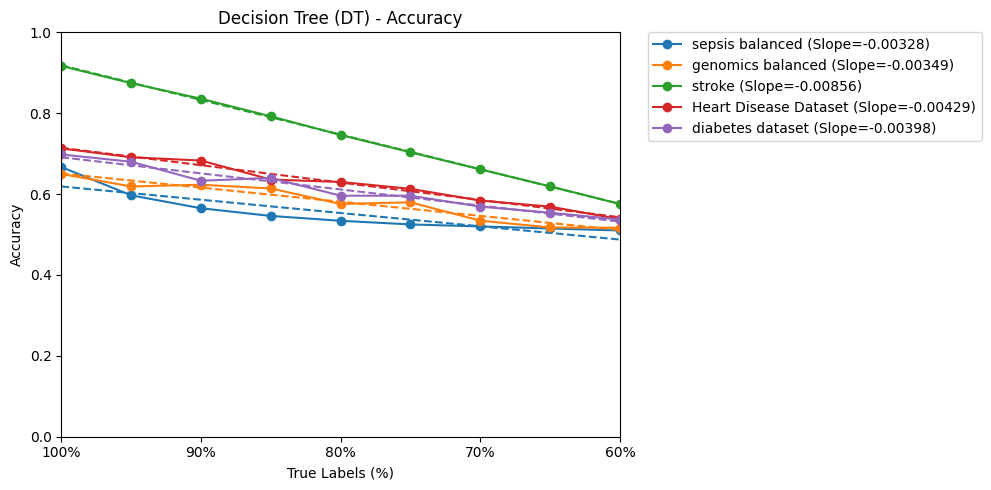

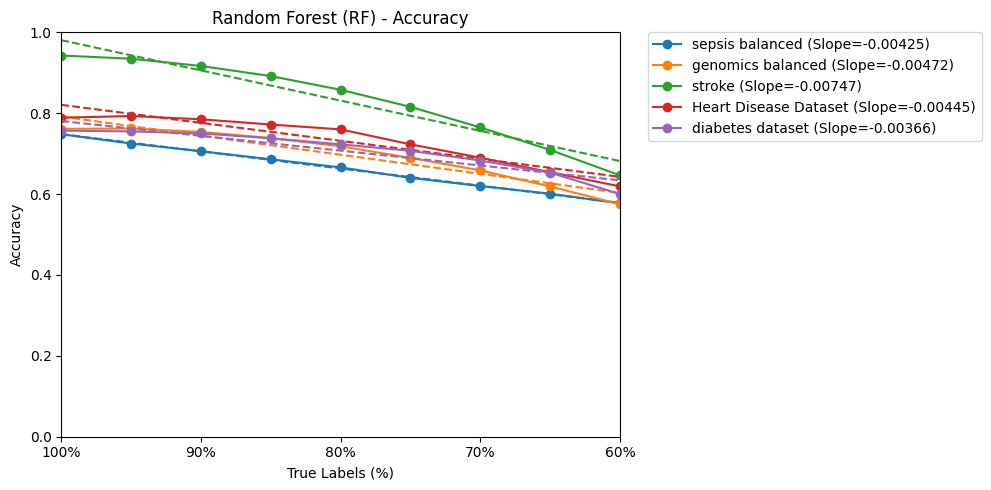

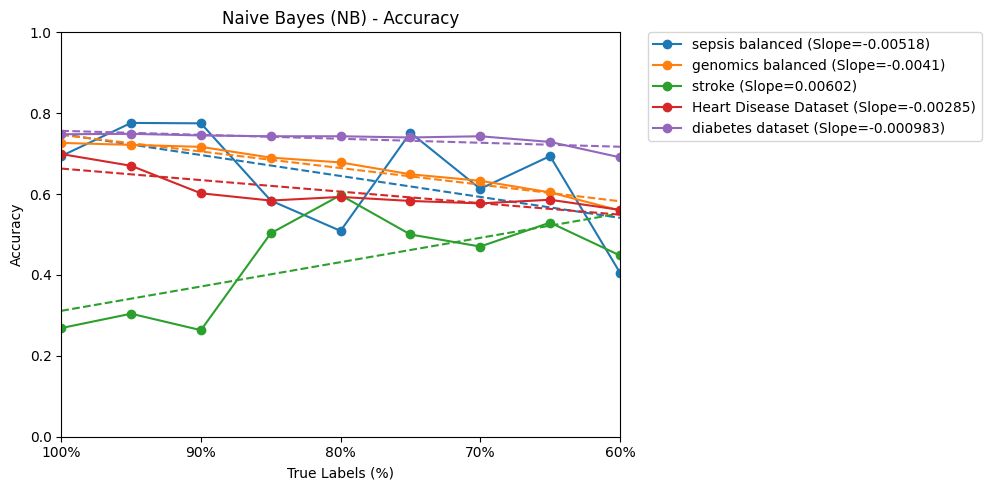

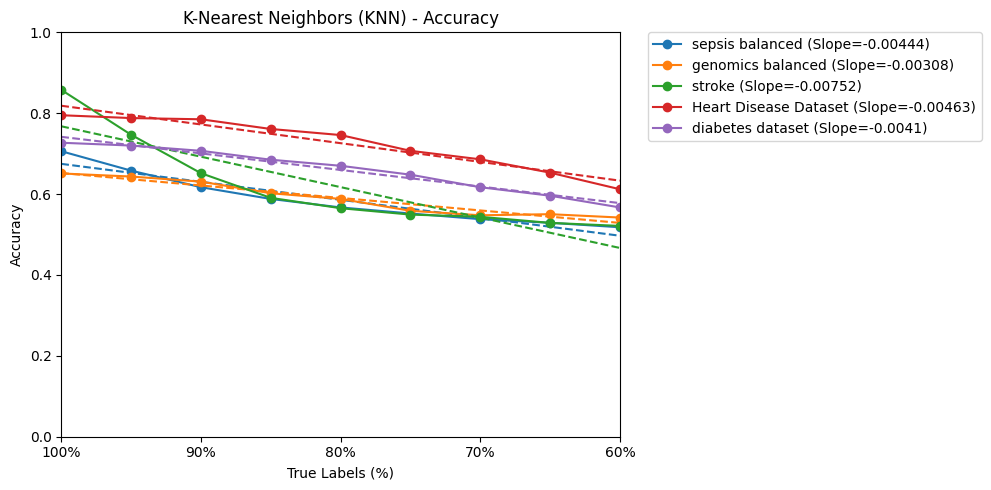

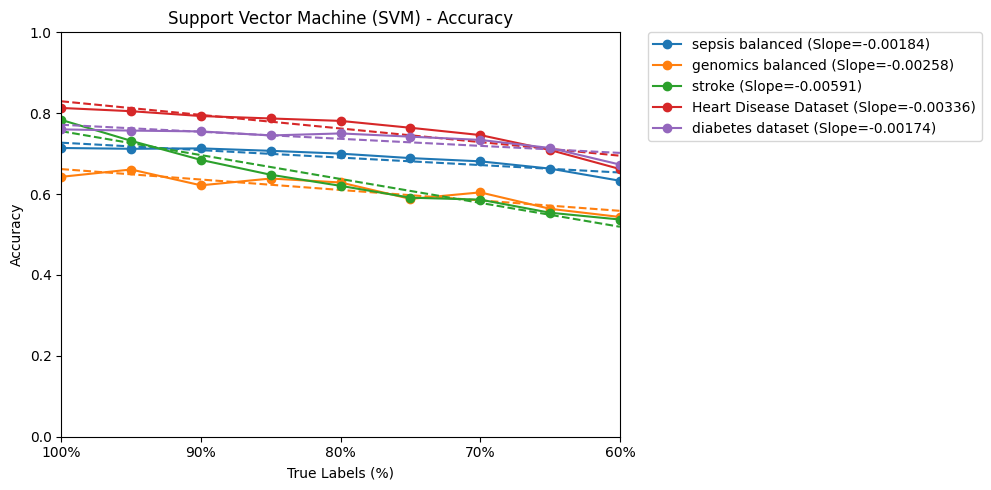

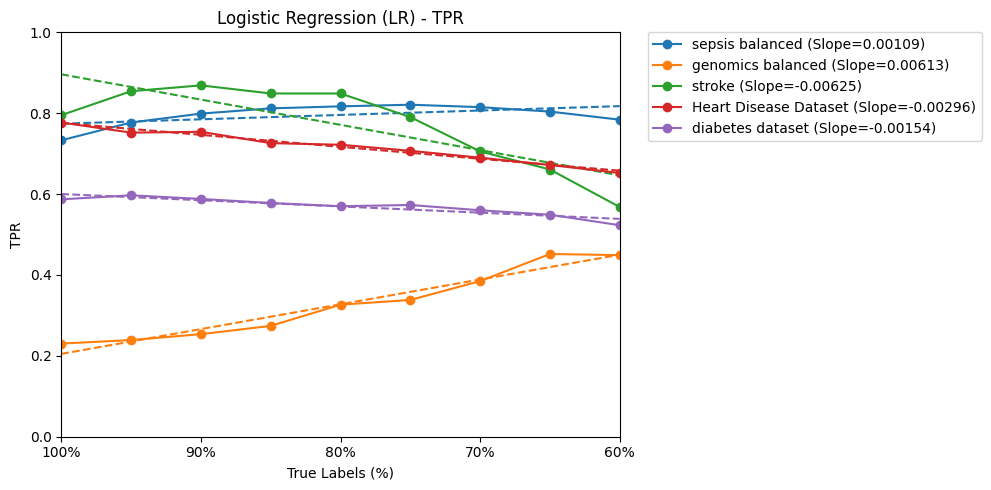

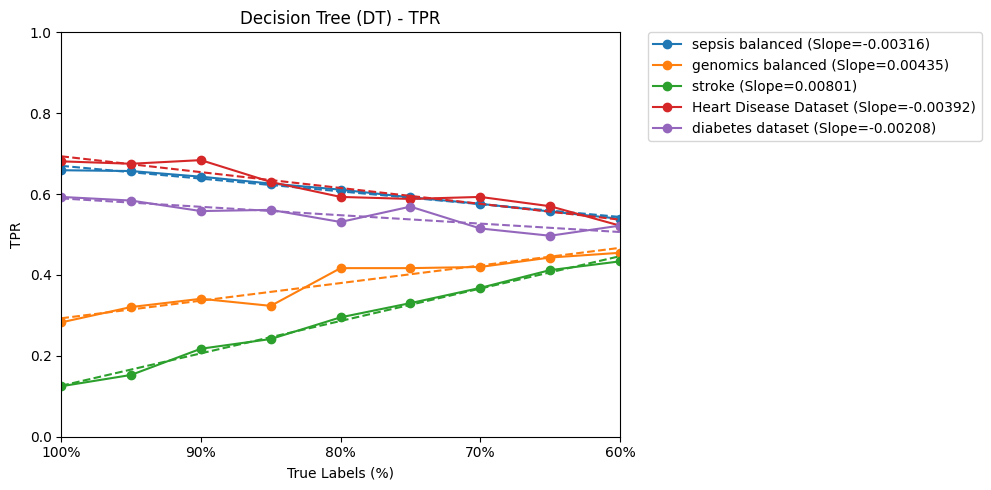

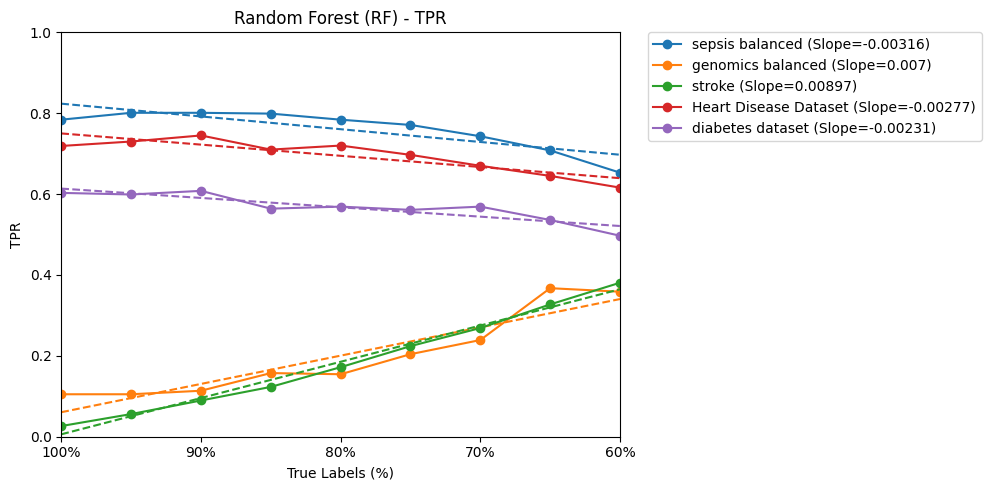

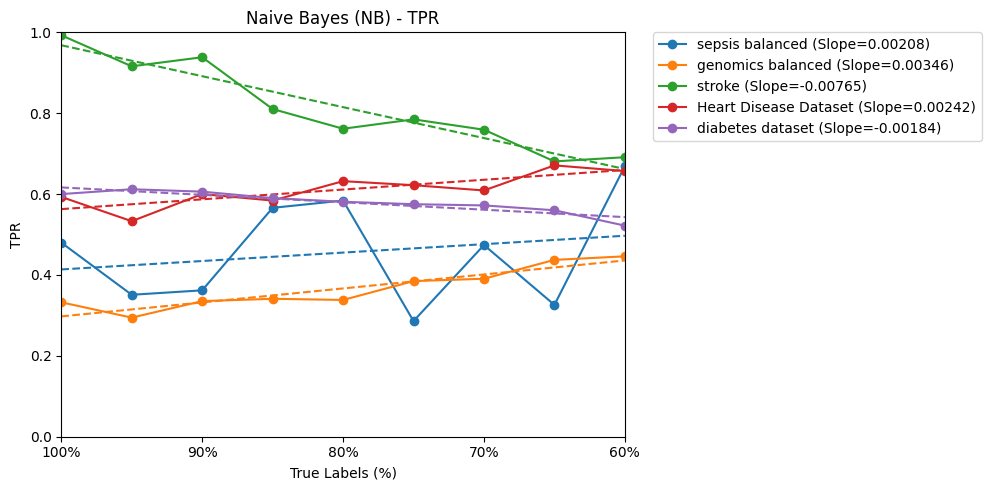

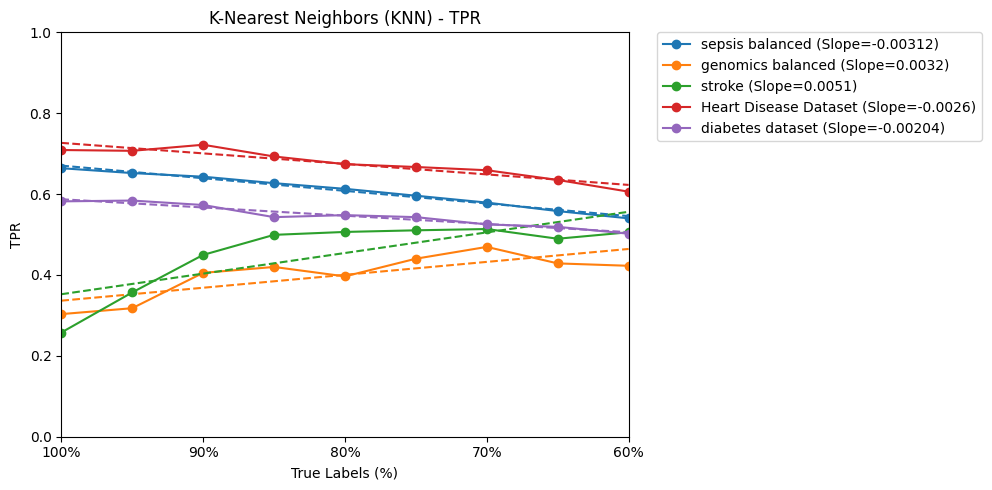

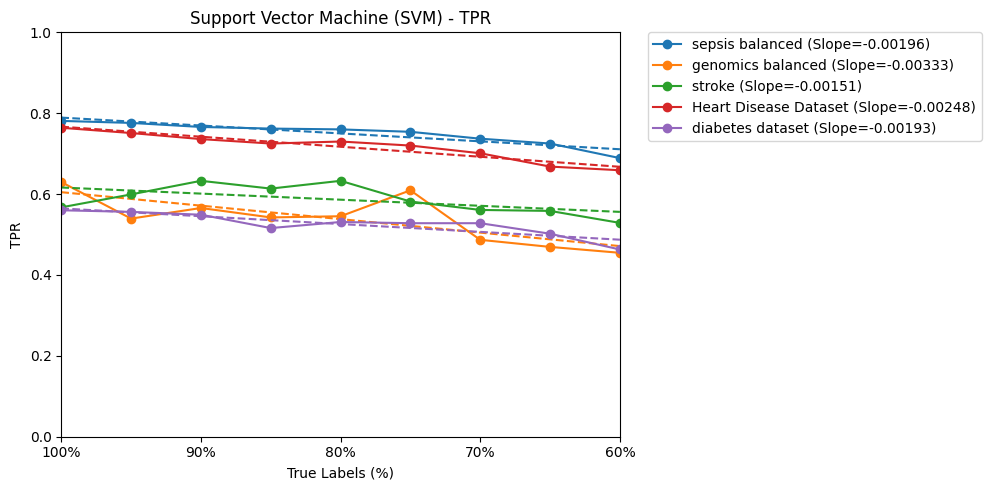

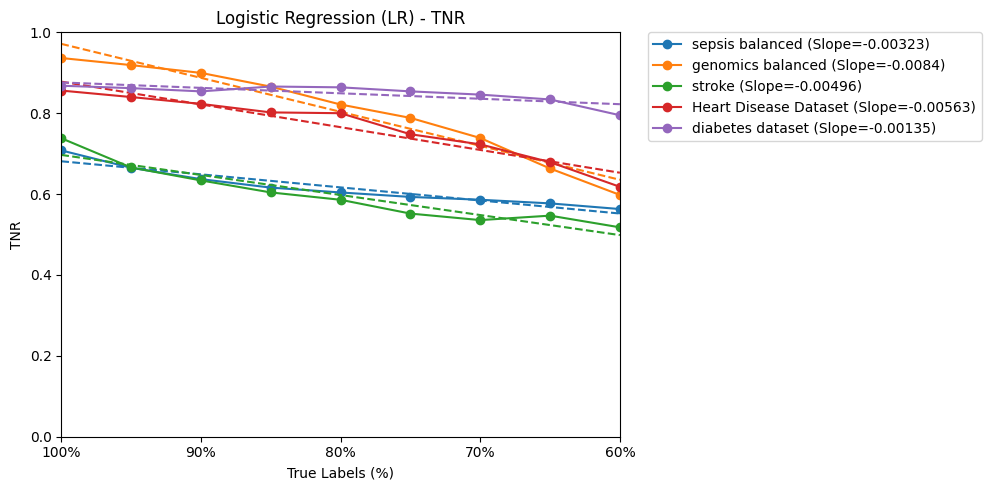

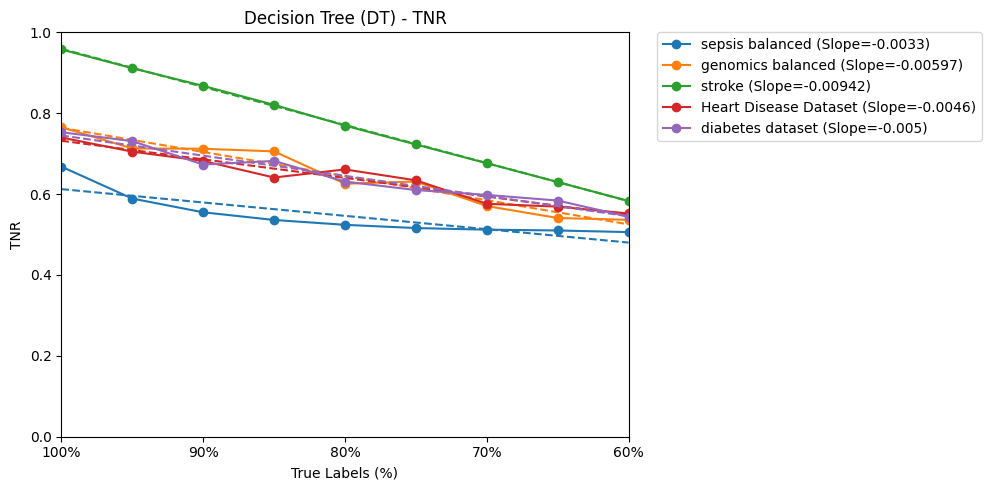

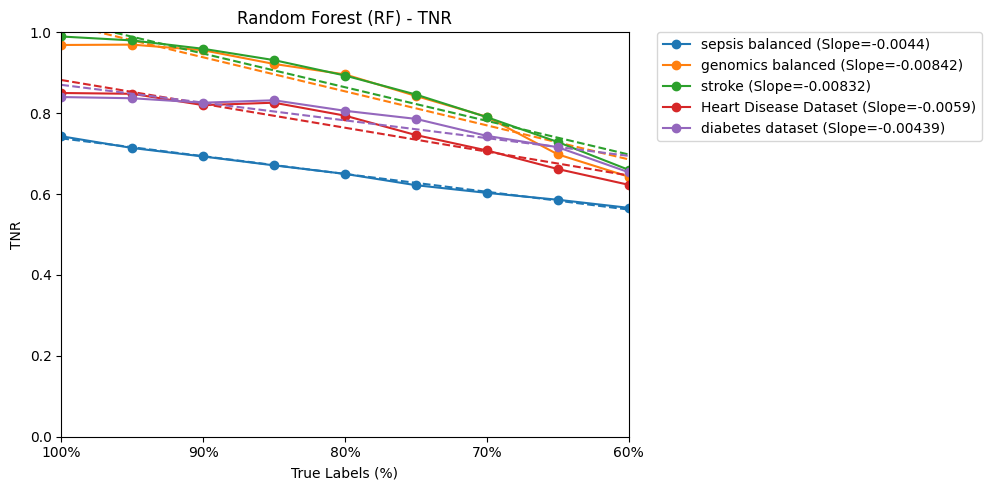

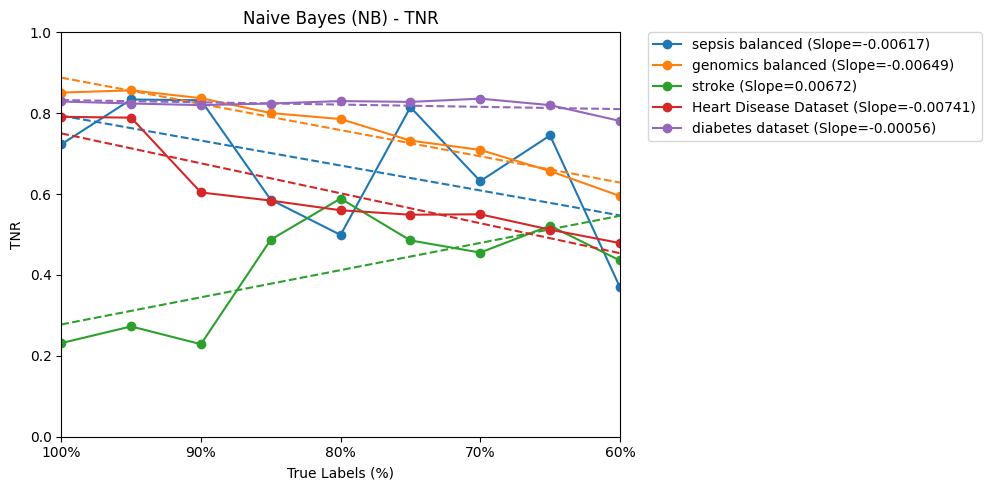

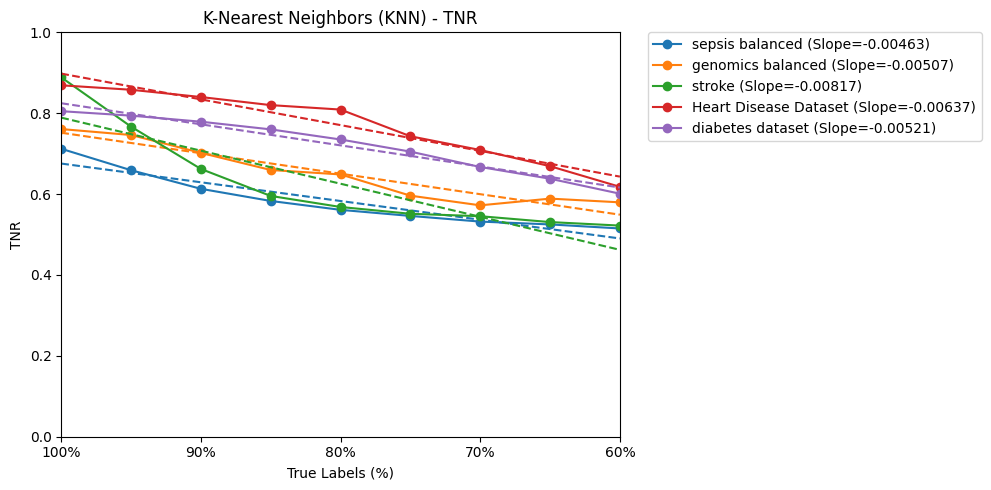

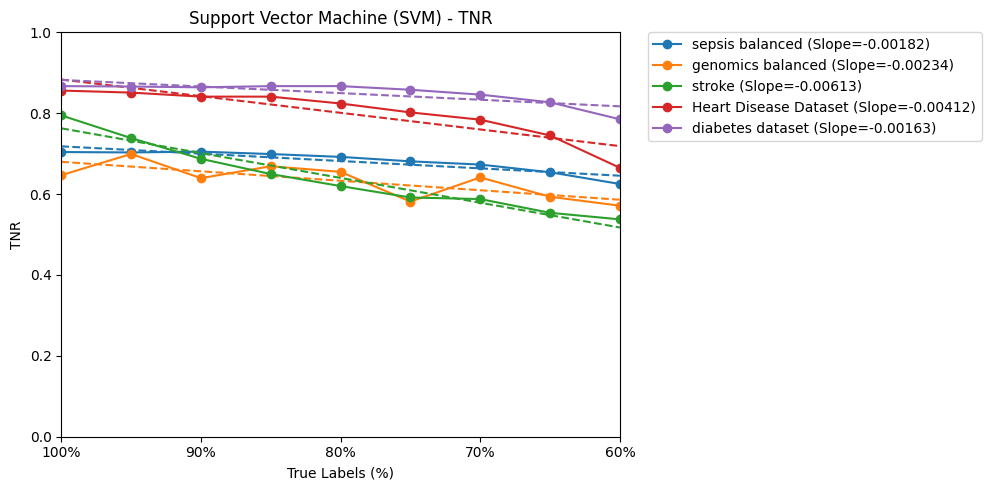

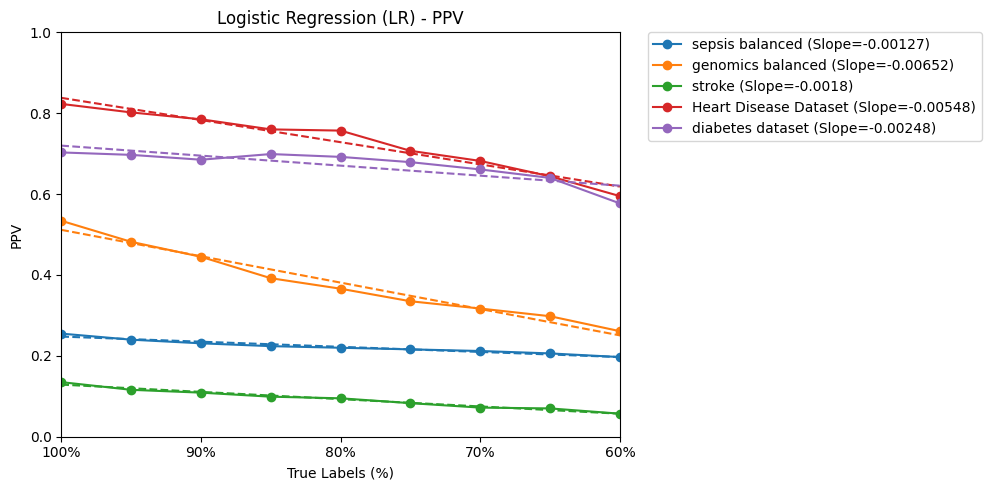

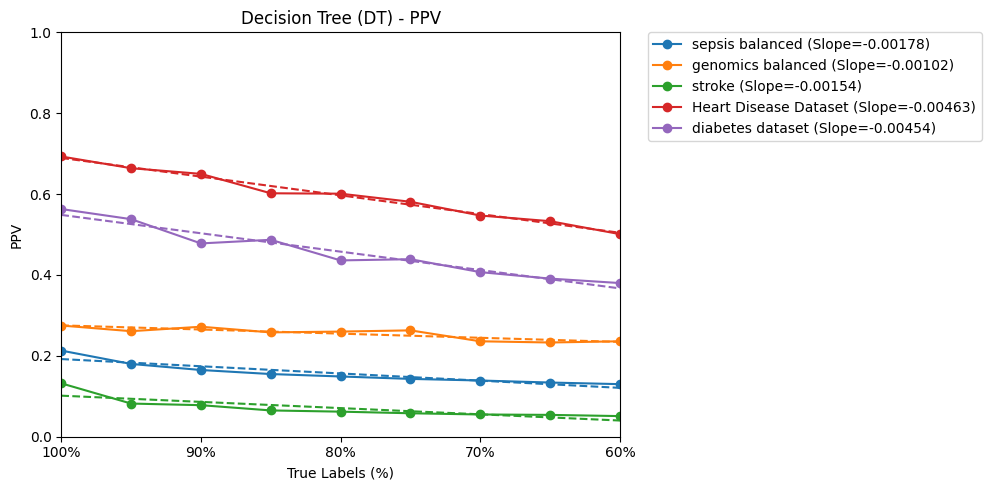

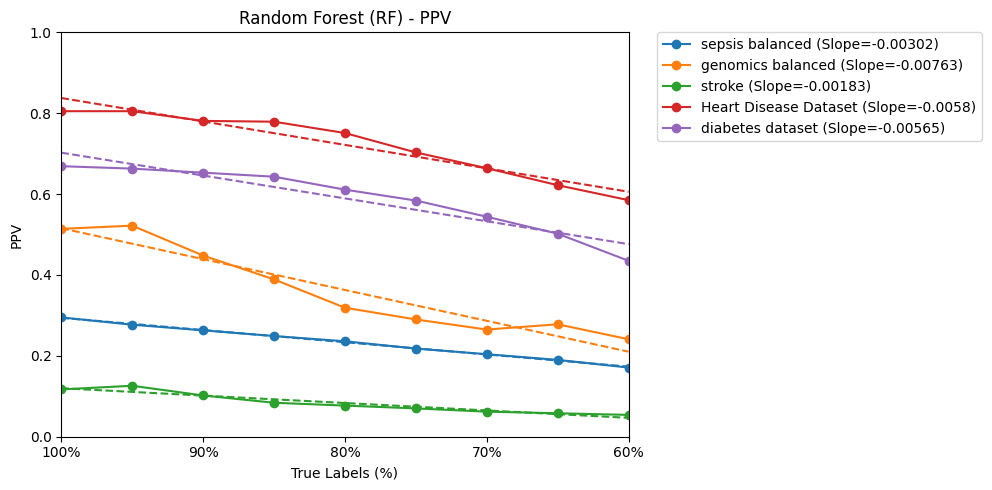

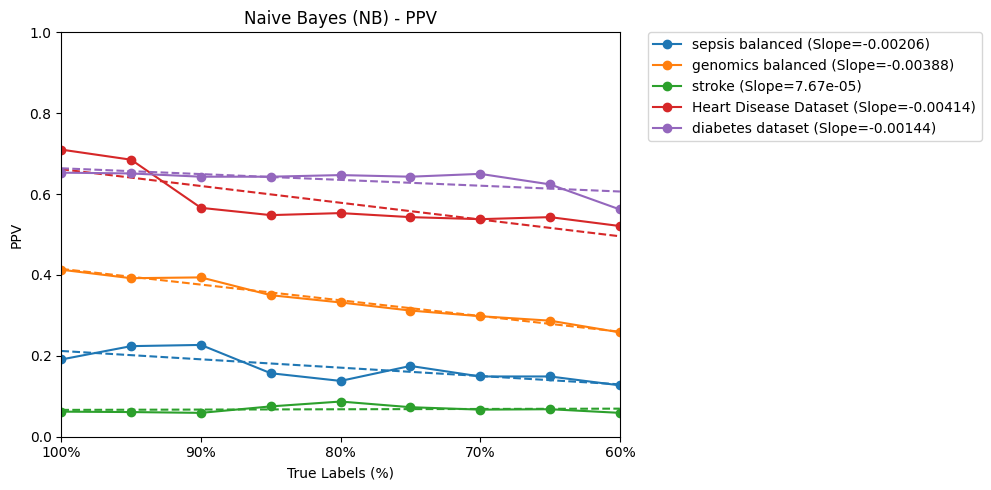

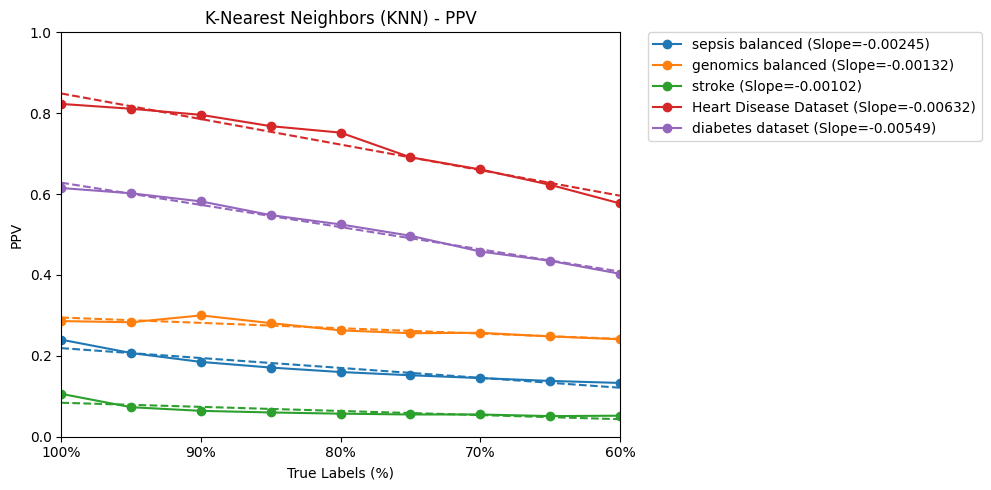

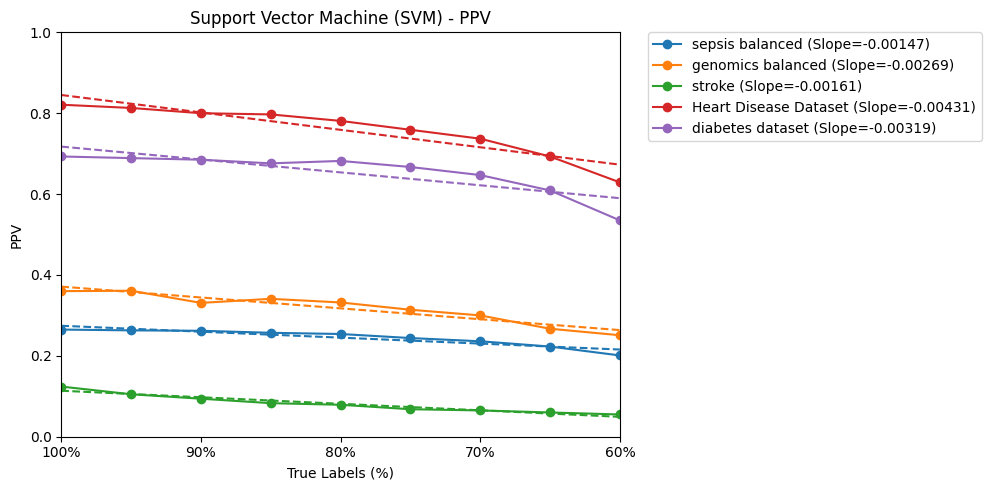

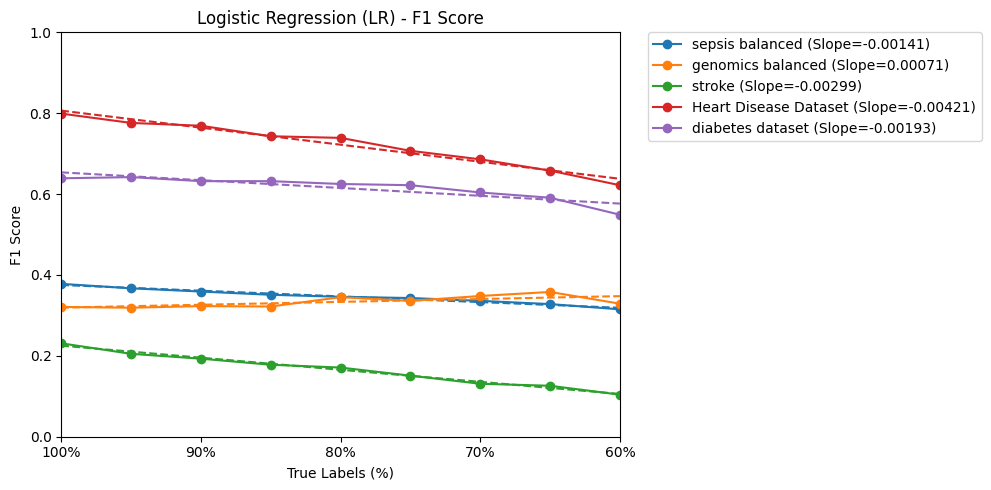

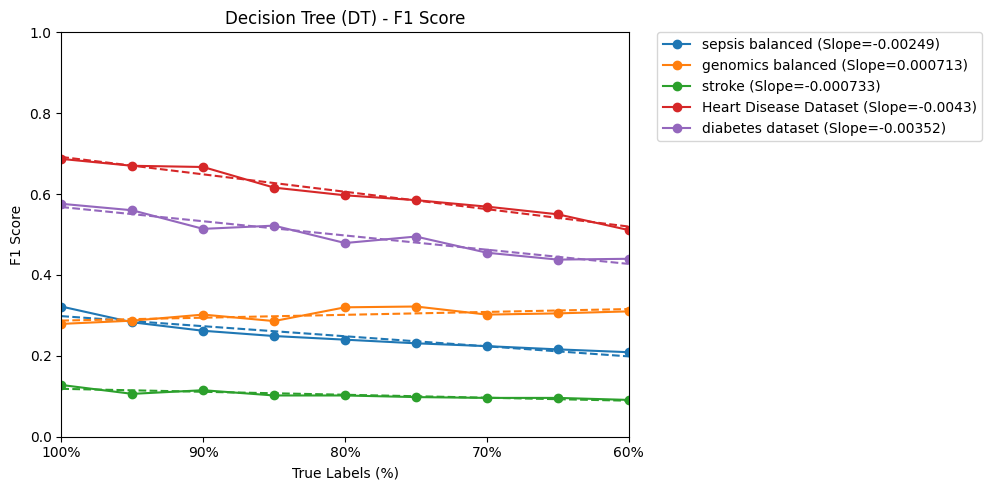

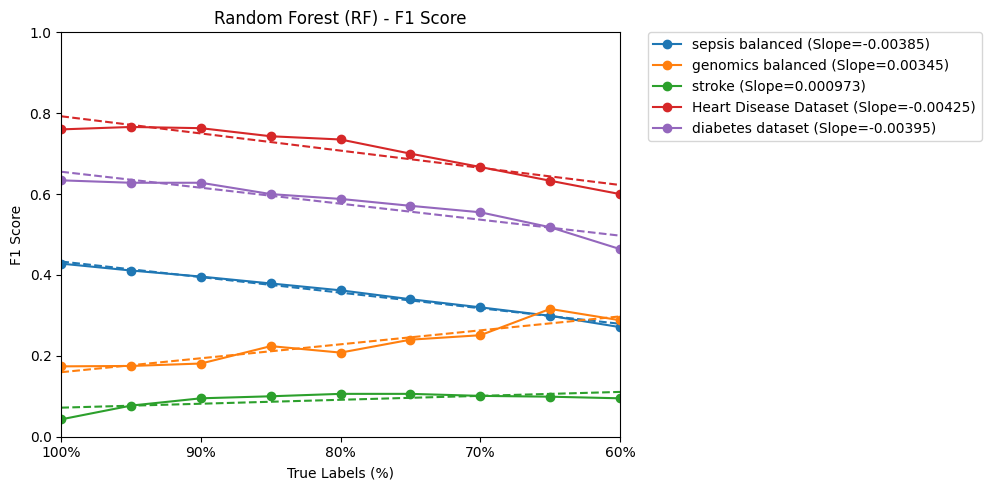

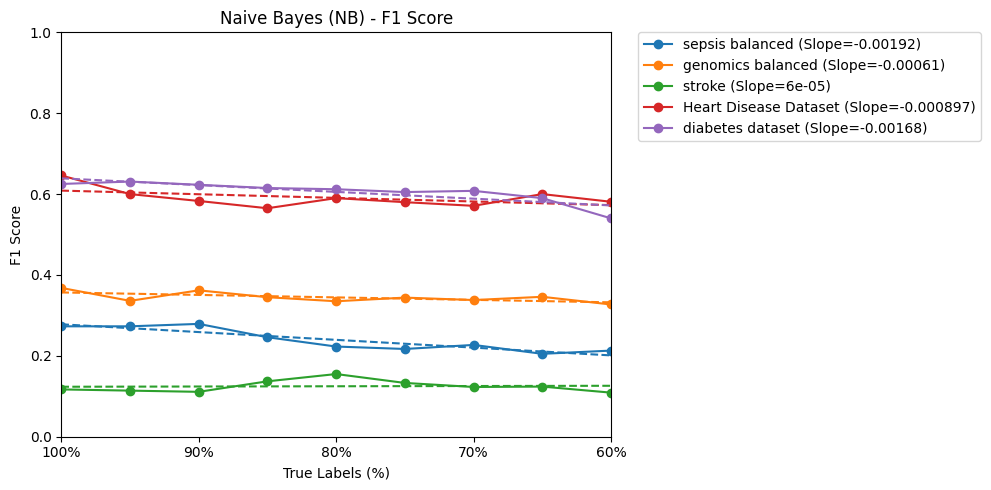

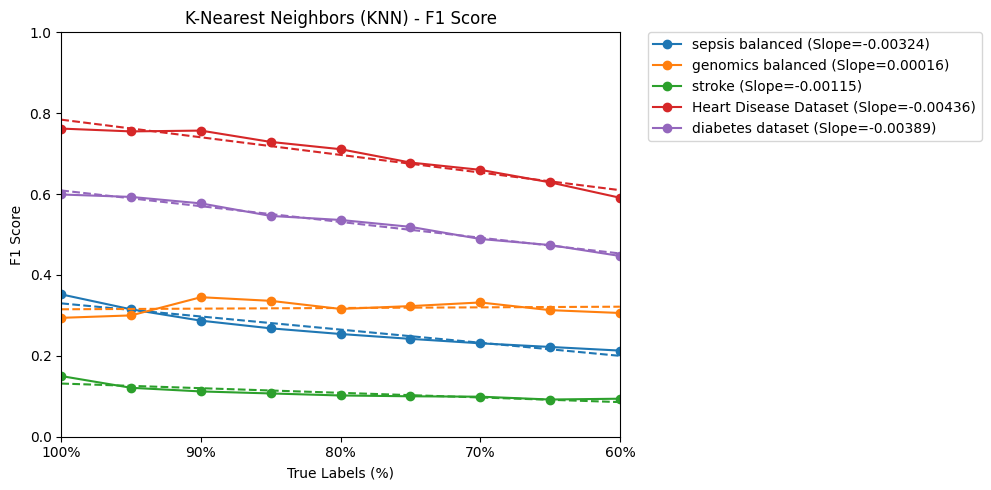

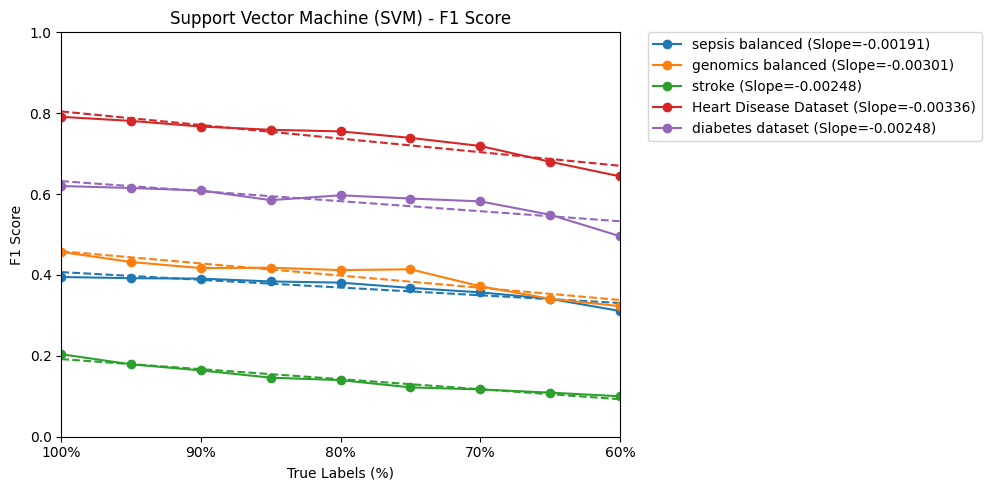

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import spearmanr
import matplotlib.pyplot as plt



df = pd.read_csv('FF_Modelevaluations.csv')


def convert_noise(noise_str):
    """Parse the Noise column which may be '5%' or just '5'."""
    if pd.isnull(noise_str):
        return np.nan
    if isinstance(noise_str, str) and '%' in noise_str:
        return float(noise_str.replace('%', ''))
    else:
        return float(noise_str)

df['Noise'] = df['Noise'].apply(convert_noise)


perf_cols = ['Accuracy', 'TPR', 'TNR', 'PPV', 'F1 Score']

def parse_metric(x):
    """Convert either a decimal string (e.g. '0.711') or a percentage string (e.g. '76.71%') to float."""
    if pd.isnull(x):
        return np.nan
    if isinstance(x, str) and '%' in x:
        return float(x.replace('%', '')) / 100.0
    else:
        return float(x)

for col in perf_cols:
    df[col] = df[col].apply(parse_metric)


metric_cols_all = ['TN', 'FP', 'FN', 'TP'] + perf_cols

results_list = []
group_keys = ['Dataset', 'Model']

for group, df_group in df.groupby(group_keys):
    if len(df_group) < 2:
        continue

    for metric in metric_cols_all:
        X = df_group['Noise'].values
        Y = df_group[metric].values

        if np.isnan(X).all() or np.isnan(Y).all():
            continue

        X_const = sm.add_constant(X, prepend=True)
        try:
            reg_result = sm.OLS(Y, X_const).fit()
            slope = reg_result.params[1]
            intercept = reg_result.params[0]
            reg_p_value = reg_result.pvalues[1]
            r_squared = reg_result.rsquared
        except:
            slope = np.nan
            intercept = np.nan
            reg_p_value = np.nan
            r_squared = np.nan

        try:
            rho, spearman_p = spearmanr(X, Y)
        except:
            rho = np.nan
            spearman_p = np.nan

        results_list.append({
            'Dataset': group[0],
            'Model': group[1],
            'Metric': metric,
            'Regression Slope': slope,
            'Regression Intercept': intercept,
            'Regression p-value': reg_p_value,
            'R-squared': r_squared,
            'Spearman rho': rho,
            'Spearman p-value': spearman_p
        })

results_df = pd.DataFrame(results_list).sort_values(by=['Dataset', 'Model', 'Metric'])

print("\nPreview of Final Regression & Spearman Correlation Results Table:")
print(results_df.head(15))

results_df.to_csv('Regression_Results.csv', index=False)
print("\nAll results have been saved to 'Regression_Results.csv'.")


metric_cols = ['Accuracy', 'TPR', 'TNR', 'PPV', 'F1 Score']

dataset_colors = {
    "sepsis balanced":        "C0",
    "genomics balanced":      "C1",
    "stroke":                 "C2",
    "Heart Disease Dataset":  "C3",
    "diabetes dataset":       "C4"
}

def get_stats(dataset, model, metric):

    row = results_df[
        (results_df['Dataset'] == dataset) &
        (results_df['Model'] == model) &
        (results_df['Metric'] == metric)
    ]
    if len(row) == 1:
        slope = row['Regression Slope'].values[0]
        intercept = row['Regression Intercept'].values[0]
        r2 = row['R-squared'].values[0]
        rho = row['Spearman rho'].values[0]
        return slope, intercept, r2, rho
    else:
        return None, None, None, None

all_models = df['Model'].unique()
all_datasets = df['Dataset'].unique()

for metric in metric_cols:
    for model in all_models:
        fig, ax = plt.subplots(figsize=(10,5))

        lines = []
        labels = []

        for dataset in all_datasets:
            subset = df[(df['Dataset'] == dataset) & (df['Model'] == model)].copy()
            if subset.empty:
                continue

            subset.sort_values('Noise', inplace=True)
            color = dataset_colors.get(dataset, None)

            (line,) = ax.plot(
                subset['Noise'],
                subset[metric],
                marker='o',
                color=color
            )

            slope, intercept, r2, rho = get_stats(dataset, model, metric)

            if slope is not None and intercept is not None:
                x_vals = np.linspace(subset['Noise'].min(), subset['Noise'].max(), 50)
                y_vals = intercept + slope * x_vals
                ax.plot(x_vals, y_vals, linestyle='--', color=color)

                label_str = (
                    f"{dataset} (Slope={slope:.3g})"
                )
            else:
                label_str = f"{dataset} (No regression)"

            lines.append(line)
            labels.append(label_str)

        ax.set_title(f"{model} - {metric}")
        ax.set_xlabel("True Labels (%)")
        ax.set_ylabel(metric)

        ax.set_xlim(0, 40)

        ax.set_xticks([0, 10, 20, 30, 40])
        ax.set_xticklabels(["100%", "90%", "80%", "70%", "60%"])

        ax.set_ylim(0, 1)

        ax.legend(
            lines,
            labels,
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0.
        )

        plt.subplots_adjust(right=0.65)

        plt.tight_layout()
        plt.show()

In [15]:
import pandas as pd


ranking_rows = []

for dataset in results_df['Dataset'].unique():
    sub = results_df[
        (results_df['Dataset'] == dataset) &
        (results_df['Metric'] == 'Accuracy')
    ].copy()

    if sub.empty or sub['Regression Slope'].isna().all():
        continue

    sub['Rank (1=Highest Slope)'] = sub['Regression Slope'].rank(
        method='dense',
        ascending=False
    )

    sub.sort_values(
        by='Regression Slope',
        ascending=False,
        inplace=True
    )

    for idx, row in sub.iterrows():
        ranking_rows.append({
            'Dataset': dataset,
            'Model': row['Model'],
            'Slope': row['Regression Slope'],
            'Rank (1=Highest Slope)': int(row['Rank (1=Highest Slope)'])
        })

ranking_df = pd.DataFrame(ranking_rows)

print("\n=== Ranking Tables (Accuracy Only) ===")
for dataset in ranking_df['Dataset'].unique():
    sub = ranking_df[ranking_df['Dataset'] == dataset].copy()
    print(f"\n--- {dataset} ---")
    print(sub[['Model', 'Slope', 'Rank (1=Highest Slope)']].to_string(index=False))

ranking_df.to_csv("Accuracy_Ranking_By_Slope.csv", index=False)
print("\nRanking saved to 'Accuracy_Ranking_By_Slope.csv'.")


=== Ranking Tables (Accuracy Only) ===

--- Heart Disease Dataset ---
                       Model     Slope  Rank (1=Highest Slope)
            Naive Bayes (NB) -0.002850                       1
Support Vector Machine (SVM) -0.003363                       2
          Decision Tree (DT) -0.004290                       3
    Logistic Regression (LR) -0.004383                       4
          Random Forest (RF) -0.004453                       5
   K-Nearest Neighbors (KNN) -0.004630                       6

--- diabetes dataset ---
                       Model     Slope  Rank (1=Highest Slope)
            Naive Bayes (NB) -0.000983                       1
    Logistic Regression (LR) -0.001427                       2
Support Vector Machine (SVM) -0.001740                       3
          Random Forest (RF) -0.003663                       4
          Decision Tree (DT) -0.003980                       5
   K-Nearest Neighbors (KNN) -0.004097                       6

--- genomics balance